<a href="https://colab.research.google.com/github/codesamskaaraH/WU_assignments/blob/main/WU_assignment_04_claasworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignmet 4

* Your task is to replace missing values in columns a2 and a14 with values estimated by a neural network (one neural network for a2 and another for a14).
* Your submission file will contain the same headers as the source CSV: a1, a2, s3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, and a16.
* You should only need to modify a2 and a14.
Neural networks can be much more powerful at filling missing variables than median and mean.
* Train two neural networks to predict a2 and a14.
* The y (target) for training the two nets will be a2 and a14, depending on which you are trying to fill.
* The x for training the two nets will be 's3','a8','a9','a10','a11','a12','a13','a15'. These are chosen because it is important not to use any columns with missing values; also, it could cause unwanted bias if we include the ultimate target (a16).
* ONLY predict new values for missing values in a2 and a14.
* You will likely get this small warning: Warning: The mean of column a14 differs from the solution file by 0.20238937709643778. (might not matter if small)

In [ ]:
import os
import pandas as pd
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import re
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot as plt
#profiling and interactive plot
import pandas_profiling
import cufflinks as cf
import plotly.offline

In [ ]:
!pip install -U plotly

     |████████████████████████████████| 13.1MB 332kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
!pip install pandas-profiling

In [ ]:
# Begin assignment
df = pd.read_csv("https://data.heatonresearch.com/data/t81-558/crx.csv",na_values=['?'])


In [ ]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
configure_plotly_browser_state()
df.iplot()

In [ ]:
df.profile_report()

In [ ]:
df.head()

a1     a2     s3 a4 a5 a6 a7    a8 a9 a10  a11 a12 a13    a14  a15 a16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202.0    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43.0  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280.0  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100.0    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120.0    0   +

In [ ]:
df['a2'].shape, df['a14'].shape

((690,), (690,))

In [ ]:
mask = pd.isna(df['a2'])

In [ ]:
mask, ~mask

(0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 685    False
 686    False
 687    False
 688    False
 689    False
 Name: a2, Length: 690, dtype: bool, 0      True
 1      True
 2      True
 3      True
 4      True
        ... 
 685    True
 686    True
 687    True
 688    True
 689    True
 Name: a2, Length: 690, dtype: bool)

In [ ]:
# determine categorical and numerical features
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
numerical_ix, categorical_ix

(Index(['a2', 's3', 'a8', 'a11', 'a14', 'a15'], dtype='object'),
 Index(['a1', 'a4', 'a5', 'a6', 'a7', 'a9', 'a10', 'a12', 'a13', 'a16'], dtype='object'))

In [ ]:
df[['s3','a8','a9','a10','a11','a12','a13','a15']]

s3    a8 a9 a10  a11 a12 a13  a15
0     0.000  1.25  t   t    1   f   g    0
1     4.460  3.04  t   t    6   f   g  560
2     0.500  1.50  t   f    0   f   g  824
3     1.540  3.75  t   t    5   t   g    3
4     5.625  1.71  t   f    0   f   s    0
..      ...   ... ..  ..  ...  ..  ..  ...
685  10.085  1.25  f   f    0   f   g    0
686   0.750  2.00  f   t    2   t   g  394
687  13.500  2.00  f   t    1   t   g    1
688   0.205  0.04  f   f    0   f   g  750
689   3.375  8.29  f   f    0   t   g    0

[690 rows x 8 columns]

In [ ]:
def transfrom_inputs(df):
    inputs = ['s3','a8','a9','a10','a11','a12','a13','a15']
    df = pd.get_dummies(df[inputs])
    return df

In [ ]:
df_inputs = transfrom_inputs(df)

In [ ]:
df_inputs.head()

s3    a8  a11  a15  a9_f  a9_t  ...  a10_t  a12_f  a12_t  a13_g  a13_p  a13_s
0  0.000  1.25    1    0     0     1  ...      1      1      0      1      0      0
1  4.460  3.04    6  560     0     1  ...      1      1      0      1      0      0
2  0.500  1.50    0  824     0     1  ...      0      1      0      1      0      0
3  1.540  3.75    5    3     0     1  ...      1      0      1      1      0      0
4  5.625  1.71    0    0     0     1  ...      0      1      0      0      0      1

[5 rows x 13 columns]

In [ ]:
def create_missing_vals_dict(df, col):   
    nans_dict = {} 
    df_nans = df[col].isna()
    idx = 1
    for i in range(len(df_nans)):
        if (df_nans[i] == True):
            nans_dict[idx] = i
            idx += 1
    return nans_dict

In [ ]:
a2_nans_dict = create_missing_vals_dict(df, 'a2')
a14_nans_dict = create_missing_vals_dict(df, 'a14')

In [ ]:
a2_nans_dict, a14_nans_dict

({1: 83,
  2: 86,
  3: 92,
  4: 97,
  5: 254,
  6: 286,
  7: 329,
  8: 445,
  9: 450,
  10: 500,
  11: 515,
  12: 608},
 {1: 71,
  2: 202,
  3: 206,
  4: 243,
  5: 270,
  6: 278,
  7: 330,
  8: 406,
  9: 445,
  10: 456,
  11: 592,
  12: 622,
  13: 626})

In [ ]:
def transform_output(df, col):
    if df[col].isna().sum():
        df[col] = df[col].fillna(0)
    return df[col]

In [ ]:
df['a2'] = transform_output(df,'a2') 
df['a14'] = transform_output(df,'a14') 


In [ ]:
df['a2'].isna().sum(), df['a14'].isna().sum()

(0, 0)

**Build pred for 'a2' and 'a14' **

In [ ]:
df_inputs['a2'] = df['a2']
df_inputs['a14'] = df['a14']


In [ ]:
df_inputs.head()

s3    a8  a11  a15  a9_f  a9_t  ...  a12_t  a13_g  a13_p  a13_s     a2    a14
0  0.000  1.25    1    0     0     1  ...      0      1      0      0  30.83  202.0
1  4.460  3.04    6  560     0     1  ...      0      1      0      0  58.67   43.0
2  0.500  1.50    0  824     0     1  ...      0      1      0      0  24.50  280.0
3  1.540  3.75    5    3     0     1  ...      1      1      0      0  27.83  100.0
4  5.625  1.71    0    0     0     1  ...      0      0      0      1  20.17  120.0

[5 rows x 15 columns]

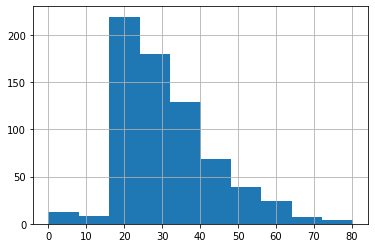

In [ ]:
df_inputs['a2'].hist()


(array([ 12.,   0.,   0.,   0.,   0.,   0., 112., 307., 204.,  55.]),
 array([0.        , 0.43975308, 0.87950616, 1.31925925, 1.75901233,
        2.19876541, 2.63851849, 3.07827157, 3.51802466, 3.95777774,
        4.39753082]),
 <a list of 10 Patch objects>)

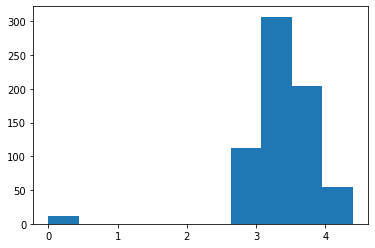

In [ ]:
log_1 = np.log(df_inputs['a2']+1)
plt.hist(log_1)

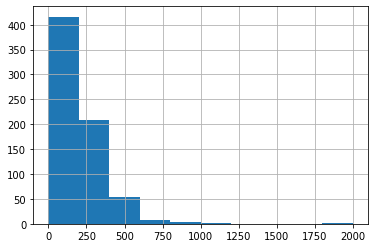

In [ ]:
df_inputs['a14'].hist()

(array([145.,   0.,   0.,   1.,  14.,  61., 231., 194.,  41.,   3.]),
 array([0.        , 0.76014023, 1.52028047, 2.2804207 , 3.04056093,
        3.80070117, 4.5608414 , 5.32098163, 6.08112187, 6.8412621 ,
        7.60140233]),
 <a list of 10 Patch objects>)

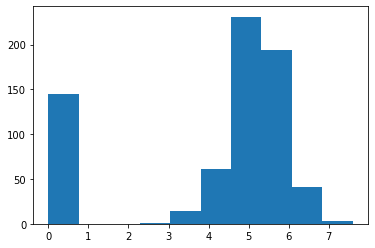

In [ ]:
# Note: NAN will be ignored by histogram
log_1 = np.log(df_inputs['a14']+1)
plt.hist(log_1)

In [ ]:
#df_train, df_test = train_test_split(df_inputs, test_size=0.25)

In [ ]:
#df_train.shape, df_test.shape

In [ ]:
df_inputs.columns

Index(['s3', 'a8', 'a11', 'a15', 'a9_f', 'a9_t', 'a10_f', 'a10_t', 'a12_f',
       'a12_t', 'a13_g', 'a13_p', 'a13_s', 'a2', 'a14'],
      dtype='object')

In [ ]:
def transform_inputs(df):
  features = ['s3', 'a8', 'a11', 'a15', 'a9_f', 'a9_t', 'a10_f', 'a10_t', 'a12_f','a12_t', 'a13_g', 'a13_p', 'a13_s']
  return df[features].values

In [ ]:
def transform_target(df, col):
  return df[col].values

In [ ]:
X_train = transform_inputs(df_inputs)
y_train_a2 = transform_target(df, 'a2')
y_train_a14 = transform_target(df, 'a14')


In [ ]:
X_train.shape, y_train_a2.shape, y_train_a14.shape

((690, 13), (690,), (690,))

In [ ]:
#X_test = transform_inputs(df_test)
#y_test = transform_target(df_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
def create_wu_3_1_model(x):

    # Build the neural network
    model = Sequential()
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(10, activation='relu')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

**Model building**


---







In [ ]:
X_train[0]

array([0.  , 1.25, 1.  , 0.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 1.  ,
       0.  , 0.  ])

In [ ]:
model_for_a2 = create_wu_3_1_model(X_train)
model_for_a14 = create_wu_3_1_model(X_train)

In [ ]:
model_for_a2.fit(X_train,np.log(y_train_a2+1),verbose=2,epochs=500)
#model_for_a14.fit(X_train,y_train_a14,verbose=2,epochs=100)


Epoch 1/500
22/22 - 0s - loss: 4.0285
Epoch 2/500
22/22 - 0s - loss: 0.8152
Epoch 3/500
22/22 - 0s - loss: 1.2029
Epoch 4/500
22/22 - 0s - loss: 5.6077
Epoch 5/500
22/22 - 0s - loss: 31.2855
Epoch 6/500
22/22 - 0s - loss: 9.1099
Epoch 7/500
22/22 - 0s - loss: 2.7178
Epoch 8/500
22/22 - 0s - loss: 2.2529
Epoch 9/500
22/22 - 0s - loss: 1.3259
Epoch 10/500
22/22 - 0s - loss: 2.4720
Epoch 11/500
22/22 - 0s - loss: 122.2150
Epoch 12/500
22/22 - 0s - loss: 344.7896
Epoch 13/500
22/22 - 0s - loss: 54.7331
Epoch 14/500
22/22 - 0s - loss: 101.5564
Epoch 15/500
22/22 - 0s - loss: 8.2259
Epoch 16/500
22/22 - 0s - loss: 54.5528
Epoch 17/500
22/22 - 0s - loss: 96.5797
Epoch 18/500
22/22 - 0s - loss: 1388.0135
Epoch 19/500
22/22 - 0s - loss: 999.0668
Epoch 20/500
22/22 - 0s - loss: 3951.8318
Epoch 21/500
22/22 - 0s - loss: 7488.5405
Epoch 22/500
22/22 - 0s - loss: 19083.3184
Epoch 23/500
22/22 - 0s - loss: 24885.4434
Epoch 24/500
22/22 - 0s - loss: 8542.0859
Epoch 25/500
22/22 - 0s - loss: 2265.5310

In [ ]:
pred_a2 = model_for_a2.predict(X_train)
print(f"Shape: {pred_a2.shape}")
print(pred_a2[0:10])

pred_a14 = model_for_a14.predict(X_train)
print(f"Shape: {pred_a14.shape}")
print(pred_a14[0:10])



Shape: (690, 1)
[[ 28.108917]
 [ 23.327477]
 [ 13.444843]
 [ 32.32955 ]
 [ 29.233   ]
 [ 30.470404]
 [-62.44184 ]
 [ 15.768761]
 [ 25.154884]
 [ 14.273216]]
Shape: (690, 1)
[[110.748886]
 [133.40158 ]
 [ 99.13127 ]
 [145.55899 ]
 [140.66446 ]
 [147.36887 ]
 [287.20618 ]
 [119.55117 ]
 [131.45865 ]
 [120.80232 ]]


Finding missing values of a2 and a14

In [ ]:
# Display a2 locations
#for i in a2_nans_dict:
 #  print("key - ", i, "val - ", a2_nans_dict[i])

In [ ]:
#df['a2'].shape, pred.shape

In [ ]:
def replace_missing_vals(miss_val_dict, pred_val, target_df, col):
    for i in miss_val_dict:
        miss_val_idx = miss_val_dict[i]
        print(col, ' prior to replacement', target_df[col][i])
        target_df[col][i]= pred_val[miss_val_idx]
        print(col, ' after  replacement', df[col][i])


In [ ]:
replace_missing_vals(a2_nans_dict, pred_a2, df, 'a2')

a2  prior to replacement 32.07750701904297
a2  after  replacement 31.086055755615234
a2  prior to replacement 24.941049575805664
a2  after  replacement 27.329944610595703
a2  prior to replacement 38.10910415649414
a2  after  replacement 38.28487777709961
a2  prior to replacement 25.048114776611328
a2  after  replacement 27.289949417114258
a2  prior to replacement 4.134037017822266
a2  after  replacement 6.304366588592529
a2  prior to replacement 23.61036491394043
a2  after  replacement 26.19048500061035
a2  prior to replacement 29.0914363861084
a2  after  replacement 27.88127899169922
a2  prior to replacement -0.03681766986846924
a2  after  replacement 1.0553202629089355
a2  prior to replacement 36.73863983154297
a2  after  replacement 36.83000183105469
a2  prior to replacement 11.655464172363281
a2  after  replacement 14.069587707519531
a2  prior to replacement 36.469791412353516
a2  after  replacement 36.09836196899414
a2  prior to replacement 31.20353889465332
a2  after  replacement

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_a2,y_train_a2))
print(f"Final score (RMSE-a2): {score}")

Final score (RMSE-a2): 20.285120501249295


In [ ]:
replace_missing_vals(a14_nans_dict, pred, df, 'a14')

a14  prior to replacement 40.75436782836914
a14  after  replacement 40.75436782836914
a14  prior to replacement 19.5268497467041
a14  after  replacement 19.5268497467041
a14  prior to replacement 28.14699363708496
a14  after  replacement 28.14699363708496
a14  prior to replacement -47.92512512207031
a14  after  replacement -47.92512512207031
a14  prior to replacement 28.14699363708496
a14  after  replacement 28.14699363708496
a14  prior to replacement 29.506587982177734
a14  after  replacement 29.506587982177734
a14  prior to replacement 28.14699363708496
a14  after  replacement 28.14699363708496
a14  prior to replacement 25.56005859375
a14  after  replacement 25.56005859375
a14  prior to replacement -0.03681766986846924
a14  after  replacement -0.03681766986846924
a14  prior to replacement 28.14699363708496
a14  after  replacement 28.14699363708496
a14  prior to replacement 28.14699363708496
a14  after  replacement 28.14699363708496
a14  prior to replacement 28.14699363708496
a14  aft

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_a14,y_train_a14))
print(f"Final score (RMSE-a14): {score}")

Final score (RMSE-a14): 186.40664814976913
